In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, source_spectrum

pynrc.setup_logging('WARNING', verbose=False)

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.


In [3]:
# Observation Definitions
from pynrc.nb_funcs import make_key, obs_wfe, obs_optimize, model_info

# Functions to run a series of operations
from pynrc.nb_funcs import do_opt, do_contrast, do_gen_hdus, do_sat_levels

# Plotting routines
from pynrc.nb_funcs import plot_contrasts, plot_contrasts_mjup, planet_mags, plot_planet_patches
from pynrc.nb_funcs import update_yscale, do_plot_contrasts, do_plot_contrasts2
from pynrc.nb_funcs import plot_hdulist, plot_images, plot_images_swlw

In [4]:
from pynrc.nb_funcs import update_yscale


## Define Sources and their Reference PSF Stars

In [5]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [6]:
# Argument list:(Name,           dist, age, sptype,  mag)
args_sources = [('proximaCen',   1.30, 4850,  'M5V',  4.38, bp_k)]

ref_sources  = [('proximaCen',   'M5V',  4.4, bp_k)]


In [7]:
# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'votables/'

# Directory to save plots and figures
outdir  = 'MDwarfs/'

In [22]:
# List of filters
args_filter = [('F444W', None, None),
#               ('F444W', None, None),
               ('F444W', 'MASK430R', 'CIRCLYOT')]

subsize = 320

filt_keys = []
for filt,mask,pupil in args_filter:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

In [9]:
save_figs = False

## proxima Centauri

In [10]:
# Fit spectrum to SED photometry
i=0
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':3042, 'metallicity':5.2, 'log_g':0.21}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,4])

# Final source spectrum
sp_sci = src.sp_model

[1.00830595]


In [11]:
sp_ref = sp_sci

In [23]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=None, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F444W_none_none
F444W_MASK430R_CIRCLYOT


In [24]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',10,600,600)
        obs.update_detectors(xpix=160, ypix=160)
        obs.nrc_ref.update_detectors(xpix=160, ypix=160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,17,17)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    print(key)
    print(obs.multiaccum_times)
    _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    print('')

F444W_none_none
{'t_frame': 0.27864, 't_group': 0.27864, 't_int': 2.7864, 't_exp': 1671.84, 't_acq': 1842.12, 't_int_tot1': 3.0702, 't_int_tot2': 3.0702}
Point Source Sensitivity (5-sigma): 22.68 vegamag
Surface Brightness Sensitivity (5-sigma): 20.61 vegamag/arcsec^2

F444W_MASK430R_CIRCLYOT
{'t_frame': 1.06904, 't_group': 10.6904, 't_int': 104.76592, 't_exp': 1781.02064, 't_acq': 1799.53296, 't_int_tot1': 105.85488, 't_int_tot2': 105.85488}
Point Source Sensitivity (5-sigma): 21.56 vegamag
Surface Brightness Sensitivity (5-sigma): 22.82 vegamag/arcsec^2



In [25]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F444W_none_none
Sci: proximaCen
  79 saturated pixel at NGROUP=2; Max Well: 114.94
  251 saturated pixel at NGROUP=10; Max Well: 574.70
  Sat Dist NG=2: 0.38 arcsec
Ref: proximaCen
  79 saturated pixel at NGROUP=2; Max Well: 114.94
  251 saturated pixel at NGROUP=10; Max Well: 574.70

F444W_MASK430R_CIRCLYOT
Sci: proximaCen
  0 saturated pixel at NGROUP=2; Max Well: 0.09
  0 saturated pixel at NGROUP=10; Max Well: 0.47
  Sat Dist NG=2: 0.00 arcsec
Ref: proximaCen
  0 saturated pixel at NGROUP=2; Max Well: 0.09
  0 saturated pixel at NGROUP=10; Max Well: 0.47


In [26]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
#curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, opt_diff=False)

F444W_none_none
F444W_MASK430R_CIRCLYOT


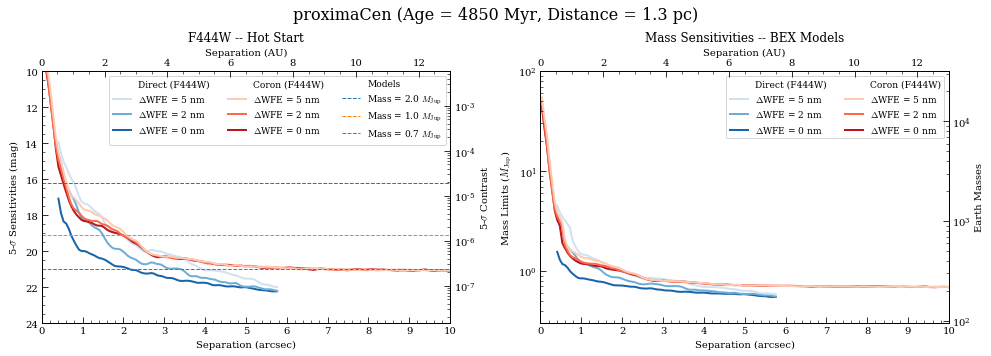

In [32]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
key1, key2 = ('F444W_none_none', 'F444W_MASK430R_CIRCLYOT')
#for curves in [curves_ref, curves_roll]:
for curves in [curves_roll]:
    lab1 = 'Direct (F444W)'
    lab2 = 'Coron (F444W)'
    fig, axes_all = do_plot_contrasts2(key1, key2, curves, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, 
                                       yr=[24,10], yscale2='log', yr2=[3e-1, 100], xr=[0,10], 
                                       linder_models=True, mass_list=[2.0,1.0,0.7], av_vals=None)

    fname = "{}_compare.pdf".format(name_sci.replace(" ", ""))
    #fig.savefig(outdir+fname)